In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.models import Model,load_model
from sklearn.preprocessing import StandardScaler, normalize
import random
%matplotlib inline


In [3]:
import os
Base_dir= r"/kaggle/input/lgg-mri-segmentation/kaggle_3m"

print(os.listdir(Base_dir))  ## print File names
print(len(os.listdir(Base_dir)))  ## print File length

['TCGA_DU_7010_19860307', 'TCGA_DU_8162_19961029', 'TCGA_FG_A4MT_20020212', 'TCGA_FG_5964_20010511', 'TCGA_DU_A5TS_19970726', 'TCGA_HT_7692_19960724', 'TCGA_DU_5849_19950405', 'TCGA_FG_A60K_20040224', 'TCGA_HT_7475_19970918', 'TCGA_FG_6691_20020405', 'TCGA_HT_7684_19950816', 'TCGA_CS_6188_20010812', 'TCGA_HT_7694_19950404', 'TCGA_DU_A5TR_19970726', 'TCGA_DU_7300_19910814', 'TCGA_DU_7018_19911220', 'TCGA_DU_7301_19911112', 'TCGA_DU_7302_19911203', 'TCGA_HT_8018_19970411', 'TCGA_FG_6692_20020606', 'TCGA_DU_5854_19951104', 'TCGA_DU_7299_19910417', 'TCGA_HT_A5RC_19990831', 'TCGA_HT_8105_19980826', 'TCGA_HT_8563_19981209', 'TCGA_HT_A61A_20000127', 'TCGA_CS_4944_20010208', 'TCGA_FG_7643_20021104', 'TCGA_DU_8163_19961119', 'TCGA_CS_6669_20020102', 'TCGA_DU_7013_19860523', 'TCGA_FG_8189_20030516', 'TCGA_HT_8111_19980330', 'TCGA_CS_5396_20010302', 'TCGA_DU_7294_19890104', 'TCGA_HT_7879_19981009', 'README.md', 'TCGA_EZ_7264_20010816', 'TCGA_DU_8164_19970111', 'TCGA_HT_7860_19960513', 'TCGA_HT_78

In [4]:
dirs = []  # id of each Brain
images = [] 
masks = [] # each Image have one mask with same Name
for ID, _, filenames in os.walk(Base_dir):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(ID.replace(Base_dir+"\\" , ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
mask_vals=[]
def posnegval(basedir,dirs,masks):
    for i in range(len(dirs)):
        mask_=os.path.join(basedir,dirs[i],masks[i])
        mask=np.array(load_img(mask_))
        value=np.max(mask)
        if value>0:
            mask_vals.append(1)
        else:
            mask_vals.append(0)
    return mask_vals
mask_vals=posnegval(Base_dir,dirs,masks)
        

In [6]:
data =pd.DataFrame({'ID':dirs,'Image':images,'Mask':masks,"Value":mask_vals})

In [7]:
data.head()

,ID,Image,Mask,Value
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_56.tif,TCGA_DU_7010_19860307_56_mask.tif,0
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_8.tif,TCGA_DU_7010_19860307_8_mask.tif,0
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_34.tif,TCGA_DU_7010_19860307_34_mask.tif,1
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif,1
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,TCGA_DU_7010_19860307_43.tif,TCGA_DU_7010_19860307_43_mask.tif,1


In [8]:
data['Value'].value_counts().index

Index([0, 1], dtype='int64', name='Value')

In [9]:
img=load_img(os.path.join(Base_dir,data.ID[3],data.Image[3]))

In [10]:
mas=load_img(os.path.join(Base_dir,data.ID[3],data.Mask[3]))

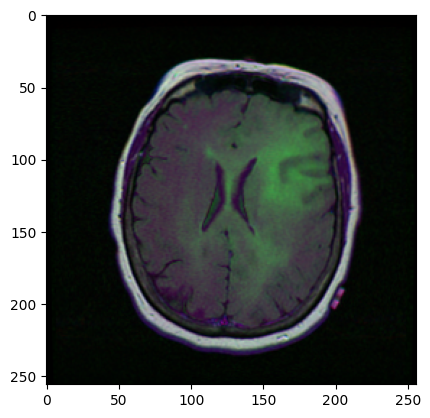

In [11]:
plt.imshow(img)

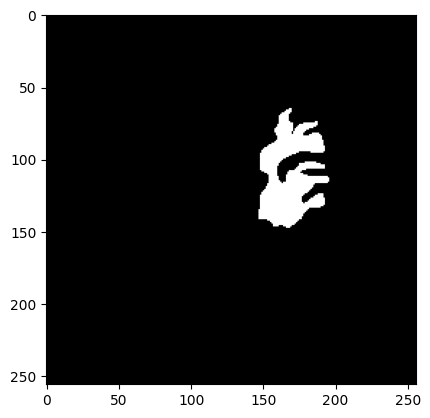

In [12]:
plt.imshow(mas)

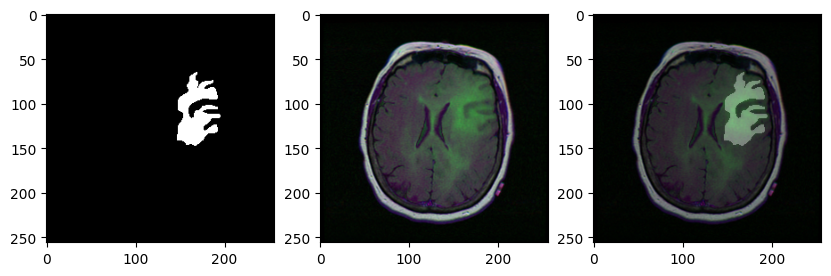

In [13]:
fig,ax=plt.subplots(1,3,figsize=(10,10))
ax[1].imshow(img)
ax[0].imshow(mas)
ax[2].imshow(img)
ax[2].imshow(mas,alpha=0.3)
plt.show()

In [14]:
data.to_csv('/kaggle/working/modified_dataset.csv', index=False)

In [13]:
data["Image"] = data['ID'] + "/" + data['Image']
data["Mask"] = data['ID'] + '/' + data['Mask']



In [14]:
from sklearn.model_selection import train_test_split


In [15]:

Train, Valid = train_test_split(data, stratify=data['Value'], test_size=0.3, random_state=42)


In [16]:
print("Train Shape : " , Train.shape)
print("Valid Shape  : " , Valid.shape)

Train Shape :  (2750, 4)
Valid Shape  :  (1179, 4)


In [17]:
Param_Aug = dict(
    rescale=1/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)



trainImg_Gen = ImageDataGenerator(**Param_Aug)
trainMask_Gen = ImageDataGenerator(**Param_Aug)
val_Gen = ImageDataGenerator(rescale=1/255)

In [18]:

# Training image generator
trainImg_gen = trainImg_Gen.flow_from_dataframe(
    dataframe=Train,
    x_col="Image",
    class_mode=None,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    seed=42
)

# Training mask generator
trainMask_gen = trainMask_Gen.flow_from_dataframe(
    dataframe=Train,
    x_col="Mask",
    class_mode=None,
    target_size=(256, 256),
    color_mode='grayscale',
    batch_size=32,
    seed=42
)

# Validation image generator
Valid_test_img = val_Gen.flow_from_dataframe(
    dataframe=Valid,
    x_col="Image",
    class_mode=None,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    seed=42
)

# Validation mask generator
Valid_test_mask = val_Gen.flow_from_dataframe(
    dataframe=Valid,
    x_col="Mask",
    class_mode=None,
    target_size=(256, 256),
    color_mode="grayscale",
    batch_size=32,
    seed=42
)

# Function to combine image and mask generators
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

train_gen = data_iterator(trainImg_gen, trainMask_gen)
valid_gen = data_iterator(Valid_test_img, Valid_test_mask)

Found 2750 validated image filenames.
Found 2750 validated image filenames.
Found 1179 validated image filenames.
Found 1179 validated image filenames.


In [19]:
from tensorflow import keras
from keras.layers import BatchNormalization,Conv2D,Activation,MaxPooling2D,Dropout,Conv2DTranspose,concatenate,Input
from keras import Model


In [20]:
def block(input, nfilters=16, kernel_size=3,dropout=0.1 ,norm=True):
    x = Conv2D(filters=nfilters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input)
    if norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=nfilters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    if norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [21]:
def unetblock(inputs,nfilters,kernal_size=3,dropout=0.1,norm=True):
    c1=block(inputs,nfilters,kernal_size,norm)
    p1=MaxPooling2D(2,2)(c1)
    p1=Dropout(dropout)(p1)
    
    c2=block(p1,nfilters*2,kernal_size,norm)
    p2=MaxPooling2D(2,2)(c2)
    p2=Dropout(dropout)(p2)
    
    c3=block(p2,nfilters*4,kernal_size,norm)
    p3=MaxPooling2D(2,2)(c3)
    p3=Dropout(dropout)(p3)
    
    c4=block(p3,nfilters*8,kernal_size,norm)
    p4=MaxPooling2D(2,2)(c4)
    p4=Dropout(dropout)(p4)
    
    c5=block(p4,nfilters*16,kernal_size,norm)
    
    u6=Conv2DTranspose(nfilters*8,(3,3),strides=(2,2),padding='same')(c5)
    u6=concatenate([u6,c4])
    u6=Dropout(dropout)(u6)
    c6=block(u6,nfilters*8,kernal_size,norm)
    
    u7=Conv2DTranspose(nfilters*4,(3,3),strides=(2,2),padding='same')(c6)
    u7=concatenate([u7,c3])
    u7=Dropout(dropout)(u7)
    c7=block(u7,nfilters*4,kernal_size,norm)
    
    u8=Conv2DTranspose(nfilters*2,(3,3),strides=(2,2),padding='same')(c7)
    u8=concatenate([u8,c2])
    u8=Dropout(dropout)(u8)
    c8=block(u8,nfilters,kernal_size,norm)
    
    u9=Conv2DTranspose(nfilters,(3,3),strides=(2,2),padding='same')(c8)
    u9=concatenate([u9,c1])
    u9=Dropout(dropout)(u9)
    c9=block(u9,nfilters,kernal_size,norm)
    
    output=Conv2D(1,(1,1),activation='sigmoid')(c9 )
    model = Model(inputs=inputs, outputs=output)
    return model
    
    
    

In [22]:
inputs=Input((256,256,3),name='img')
model=unetblock(inputs,16,3,0.1,True)
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [24]:
callbacks=[
    EarlyStopping(patience=10,verbose=1),
    ReduceLROnPlateau(patience=5,factor=0.1,min_lr=1e-5,verbose=1),
    ModelCheckpoint('brain_tumor_model.weights.h5',verbose=1,save_best_only=True,save_weights_only=True)

]

In [25]:
import warnings
import cv2
warnings.filterwarnings('ignore')

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(trainImg_gen),
    epochs=20,
    validation_data=valid_gen,
    validation_steps=len(Valid_test_img),
    callbacks=callbacks 
)


Epoch 1/20


I0000 00:00:1732014341.714928      83 service.cc:145] XLA service 0x7f4e780045c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732014341.714991      83 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732014341.714995      83 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732014382.851608      83 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8389 - loss: 0.4579   
Epoch 1: val_loss improved from inf to 3.36478, saving model to brain_tumor_model.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8400 - loss: 0.4561 - val_accuracy: 0.6332 - val_loss: 3.3648 - learning_rate: 0.0010
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.9912 - loss: 0.1347
Epoch 2: val_loss improved from 3.36478 to 1.30981, saving model to brain_tumor_model.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 644ms/step - accuracy: 0.9912 - loss: 0.1346 - val_accuracy: 0.8004 - val_loss: 1.3098 - learning_rate: 0.0010
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9893 - loss: 0.0968
Epoch 3: val_loss improved from 1.30981 to 0.08731, saving model to brain_tumor_model.weights.h5
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 644ms/step - accuracy: 0.9893 - loss: 0.0966 - val_accuracy: 0.9912 - val_loss: 0.0873 - learning_rate: 0.0010
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5

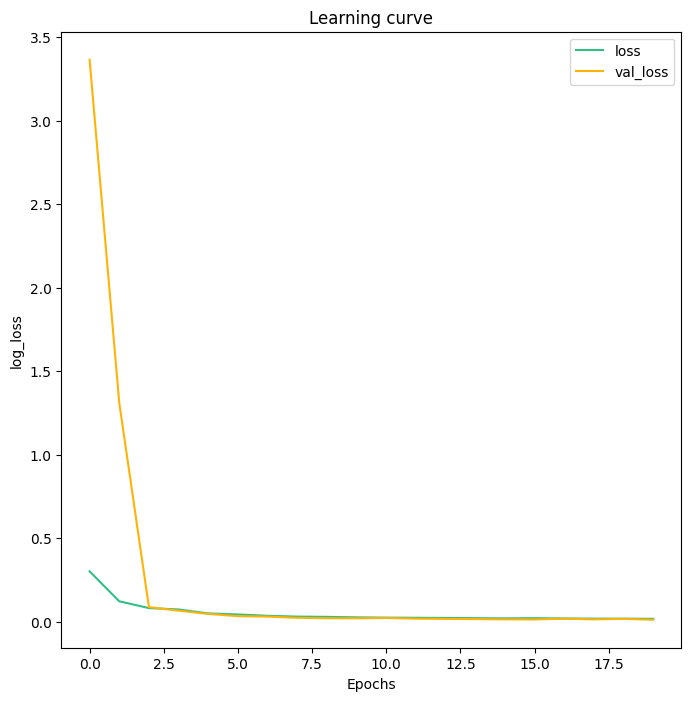

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(history.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
plt.show()

In [8]:
import os
print(os.listdir('/kaggle/working/'))

['.virtual_documents']


In [30]:
model.save('/kaggle/working/my_model.h5')  
